## OODA (Ovserve->Orient->Decide-Act)

In [2]:
# Observe
from typing import TypedDict, Annotated, Literal
from operator import add
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

In [24]:
# state definition for OODA agent
class OODAState(TypedDict):
    user_input: str

    # observation phase
    observations: Annotated[list[str], add]
    context: dict

    # orient
    analysis: str
    understanding: str

    # decide
    decision: str
    action_plan: str

    # act
    action_result: str

    # control
    current_phase: Literal["observe", "orient", "decide", "act", "complete"]
    iteration: Annotated[int, add]
    max_iterations: int

In [25]:
llm = ChatOllama(model="llama3.2", temperature=0.7)

In [47]:
def observe(state: OODAState) -> dict:
    """OBSERVE: Gather and analyze initial information"""
    observations = []
    user_query = state["user_input"]
    observations.append(f"User request: {user_query}")
    
    # More explicit prompting for local models
    system_prompt = """You are an expert analyst. Your job is to carefully observe and analyze requests.

TASK: Analyze the user's request and identify:
1. What is the main question or goal?
2. What type of information is needed to answer?
3. Are there any ambiguities or missing details?
4. What challenges might arise in answering this?

Keep your analysis clear and structured."""
    
    user_prompt = f"""USER REQUEST: "{user_query}"

Now analyze this request following the 4 points above. Be specific and concise."""
    
    analysis = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_prompt)
    ])
    
    observations.append(f"Initial analysis: {analysis.content}")
    
    return {
        "observations": observations,
        "context": {
            "query_length": len(user_query),
            "query_type": "question" if "?" in user_query else "statement"
        },
        "current_phase": "orient"  # ← Node sets next phase
    }

In [48]:
def orient(state: OODAState) -> dict:
    """ORIENT: Synthesize observations into understanding"""
    all_obs = "\n".join(state["observations"])
    
    system_prompt = """You are an expert at synthesizing information and forming clear understanding.

TASK: Based on the observations provided, create a clear understanding by:
1. Identifying the CORE question or need
2. Determining the BEST approach to address it
3. Noting any IMPORTANT context or constraints

Format your response as:
CORE QUESTION: [state the main question]
APPROACH: [describe the best way to handle this]
CONTEXT: [any important notes]"""
    
    user_prompt = f"""OBSERVATIONS:
{all_obs}

Now provide your understanding in the format specified above."""
    
    understanding = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_prompt)
    ])
    
    # Extract a brief analysis for state
    analysis_brief = understanding.content.split('\n')[0][:150]
    
    return {
        "analysis": analysis_brief,
        "understanding": understanding.content,
        "current_phase": "decide"  # ← Node sets next phase
    }

In [49]:
def decide(state: OODAState) -> dict:
    """DECIDE: Make a clear decision on what action to take"""
    
    system_prompt = """You are a decision-maker. Your job is to decide the best action based on your understanding.

TASK: Decide what action to take. Choose ONE of these options:
1. ANSWER_DIRECTLY - You have enough information to answer the question directly
2. NEED_MORE_INFO - You need to ask clarifying questions
3. SEARCH_REQUIRED - You need to search for external information
4. COMPLEX_REASONING - The question requires step-by-step reasoning

Format your response as:
DECISION: [one of the 4 options above]
REASONING: [brief explanation why]
NEXT_STEP: [what specifically to do]"""
    
    user_prompt = f"""CURRENT UNDERSTANDING:
{state['understanding']}

ORIGINAL QUESTION: {state['user_input']}

Now make your decision using the format above."""
    
    decision = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_prompt)
    ])
    
    decision_content = decision.content
    
    # Extract decision type for action plan
    decision_type = "ANSWER_DIRECTLY"  # default
    if "NEED_MORE_INFO" in decision_content:
        decision_type = "NEED_MORE_INFO"
    elif "SEARCH_REQUIRED" in decision_content:
        decision_type = "SEARCH_REQUIRED"
    elif "COMPLEX_REASONING" in decision_content:
        decision_type = "COMPLEX_REASONING"
    
    return {
        "decision": decision_content,
        "action_plan": f"Execute {decision_type} strategy",
        "current_phase": "act"  # ← Node sets next phase
    }

In [50]:
def act(state: OODAState) -> dict:
    """ACT: Execute the decision and provide final response"""
    
    system_prompt = """You are a helpful AI assistant. Your job is to provide clear, accurate, and helpful responses.

TASK: Based on the action plan and decision made, provide a complete response to the user's original question.

Guidelines:
- Be clear and direct
- Use examples when helpful
- Structure your response well
- If you're uncertain, say so
- Keep it concise but complete"""
    
    user_prompt = f"""ACTION PLAN: {state['action_plan']}

DECISION DETAILS:
{state['decision']}

ORIGINAL QUESTION: {state['user_input']}

Now provide your complete response to the user."""
    
    result = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_prompt)
    ])
    
    return {
        "action_result": result.content,
        "iteration": 1,
        "current_phase": "complete"  # ← Node sets next phase
    }

In [53]:
def route_phase(state: OODAState) -> str:
    """Route based on the phase that nodes have already determined"""
    current = state["current_phase"]
    
    # Special handling for act phase to enable looping
    if current == "complete":
        # Check if we should loop for improvement
        if state["iteration"] < state["max_iterations"]:
            # Check if response seems incomplete (optional improvement logic)
            if len(state.get("action_result", "")) < 50:
                return "observe"  # Loop back for refinement
        return "end"  # Done - exit the loop
    
    # For all other phases, simply go where the node indicated
    return current

In [54]:
# Build the graph
workflow = StateGraph(OODAState)

# Add all phases as nodes
workflow.add_node("observe", observe)
workflow.add_node("orient", orient)
workflow.add_node("decide", decide)
workflow.add_node("act", act)

# Set entry point
workflow.set_entry_point("observe")

# Add routing from each phase
for phase in ["observe", "orient", "decide", "act"]:
    workflow.add_conditional_edges(
        phase,
        route_phase,
        {
            "observe": "observe",
            "orient": "orient",
            "decide": "decide",
            "act": "act",
            "end": END
        }
    )

# Compile
app = workflow.compile()

In [55]:
from IPython.display import Image, display

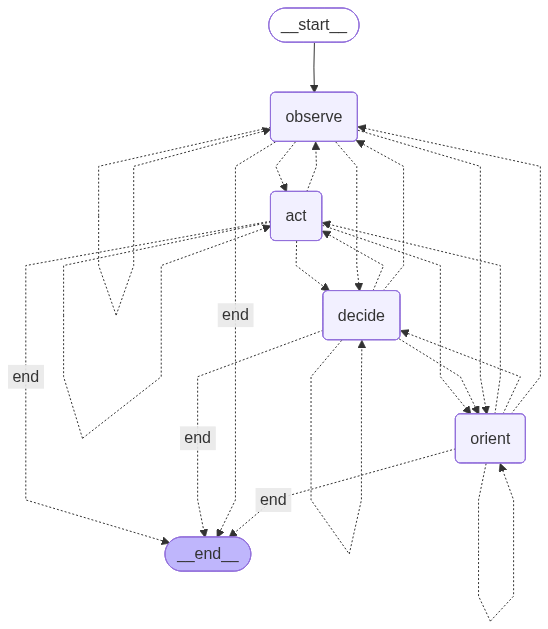

In [56]:
display(Image(app.get_graph().draw_mermaid_png()))

In [57]:
def run_ooda_agent(question: str, max_iter: int = 2):
    """Run OODA agent with a question"""
    
    initial_state = {
        "user_input": question,
        "observations": [],
        "context": {},
        "analysis": "",
        "understanding": "",
        "decision": "",
        "action_plan": "",
        "action_result": "",
        "current_phase": "observe",
        "iteration": 0,
        "max_iterations": max_iter
    }
    
    print(f"\n{'='*60}")
    print(f"QUESTION: {question}")
    print(f"{'='*60}\n")
    
    # Stream through phases
    for step in app.stream(initial_state):
        for node_name, node_output in step.items():
            phase = node_output.get("current_phase", "unknown")
            print(f"📍 Phase: {phase.upper()}")
            
            if phase == "observe":
                print(f"   Observations: {len(node_output.get('observations', []))}")
            elif phase == "orient":
                print(f"   Analysis: {node_output.get('analysis', '')[:80]}...")
            elif phase == "decide":
                print(f"   Decision: {node_output.get('decision', '')[:80]}...")
            elif phase == "complete":
                print(f"\n✅ FINAL RESULT:")
                print(f"{node_output.get('action_result', '')}\n")
            
            print()
    
    return app.invoke(initial_state)

In [58]:
# Test 1: Simple question
result1 = run_ooda_agent(
    "What are the main benefits of using local LLMs like Ollama?"
)


QUESTION: What are the main benefits of using local LLMs like Ollama?

📍 Phase: ORIENT
   Analysis: ...

📍 Phase: DECIDE
   Decision: ...

📍 Phase: ACT

📍 Phase: COMPLETE

✅ FINAL RESULT:
**Response**

Thank you for executing our ACTION PLAN and following up on the NEED_MORE_INFO strategy.

Unfortunately, without more specific context about your industry, application domain, or requirements, it's challenging to accurately identify the main benefits of using local LLMs like Ollama.

To provide a more informed response, I'd like to ask: **What specific use case or industry are you considering for using local LLMs?** This will help me understand your unique needs and requirements, which will enable me to provide more targeted guidance on the benefits of using local LLMs like Ollama.

Please feel free to share any relevant details, such as:

* Your industry or sector (e.g., healthcare, finance, education)
* The specific application domain you're exploring (e.g., text analysis, sentiment a

In [59]:
result2 = run_ooda_agent(
        "Explain how the OODA loop applies to AI agent design"
    )


QUESTION: Explain how the OODA loop applies to AI agent design

📍 Phase: ORIENT
   Analysis: ...

📍 Phase: DECIDE
   Decision: ...

📍 Phase: ACT

📍 Phase: COMPLETE

✅ FINAL RESULT:
**Explaining the OODA Loop in AI Agent Design**

The OODA loop, developed by Colonel John Boyd, is a decision-making framework that has been widely adopted in various fields, including military strategy and business operations. In the context of AI agent design, understanding the OODA loop is essential to create intelligent systems that can adapt to complex environments.

**Step 1: Define the OODA Loop**

The OODA loop consists of four stages:

1. **Observe**: Gather information about the environment.
2. **Orient**: Analyze and understand the information gathered.
3. **Act**: Make a decision based on the analysis.
4. **Decide**: Adjust the course of action based on the outcome.

The OODA loop is designed to facilitate rapid decision-making by creating an iterative process that allows for continuous learning